In [1]:
import tensorflow as tf

In [2]:
import tensorflow_datasets as tfds

In [3]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'booksum',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'cs_restaurants',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_adroit_door',
 'd4rl_adr

In [4]:
import matplotlib.pyplot as plt

In [5]:
dataset, info = tfds.load('tf_flowers',as_supervised=True,
                                        with_info=True)

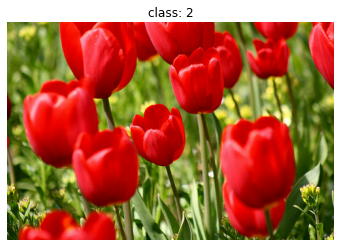

In [31]:
for image, label in dataset['train'].take(1):
    plt.imshow(image)
    plt.axis('off')
    plt.title('class: {}'.format(label))

In [6]:
# as_supervised 를 True로 지정해주면 imges와 label로 데이터를 구분해줌
train_set, valid_set, test_set= tfds.load('tf_flowers',as_supervised=True,
                                                   split=['train[:75%]','train[75%:90%]','train[90%:]'])

In [7]:
dataset_size = info.splits['train'].num_examples

In [8]:
dataset_size

3670

In [9]:
class_names = info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [16]:
n_classes = info.features['label'].num_classes
n_classes

5

In [10]:
info.features['image']

Image(shape=(None, None, 3), dtype=tf.uint8)

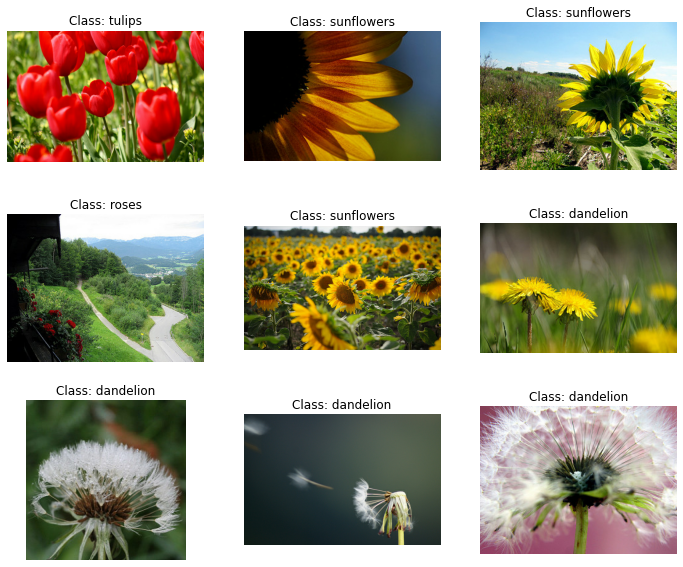

In [13]:
plt.figure(figsize=(12,10))
index = 0
for image, label in train_set.take(9):
    index +=1
    plt.subplot(3,3,index)
    plt.imshow(image)
    plt.title('Class: {}'.format(class_names[label]))
    plt.axis('off')
plt.show()

In [12]:
# def preprocess(image,label):
#     resized_image =tf.image.resize(image,[224,224])
#     final_image = keras.applications.xception.preprocess_input(resized_image)
#     return final_image, label


def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0],shape[1]])
    top_crop = (shape[0]-min_dim) //4
    bottom_crop = shape[0]-top_crop
    left_crop = (shape[1]-min_dim) //4
    right_crop = shape[1]-left_crop
    return image[top_crop:bottom_crop,left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0],shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim,min_dim,3])

def preprocess(image,label, randomize = False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resize_image = tf.image.resize(cropped_image,[224,224])
    final_image = keras.applications.xception.preprocess_input(resize_image)
    return final_image, label

In [14]:
from functools import partial
from tensorflow import keras
batch_size = 32
train_set = train_set.shuffle(1000).repeat()
train_set_ = train_set.map(partial(preprocess,randomize=True)).batch(batch_size).prefetch(1)
valid_set_ = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set_ = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [17]:
base_model = keras.applications.xception.Xception(weights='imagenet',
                                                 include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes,
                           activation='softmax')(avg)
model = keras.Model(inputs=[base_model.input],outputs=[output])

In [94]:
for layer in base_model.layers:
    layer.trainable = False # 기존의 모델을 사용할 때는 사전훈련된 층의 가중치를 동결하는 것이 좋음
    # 가중치를 동결하거나 해제한 경우 그 뒤에 컴파일을 해줘야 함

In [95]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_4
13 block2_pool
14 batch_normalization_4
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_5
23 block3_pool
24 batch_normalization_5
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_6
33 block4_pool
34 batch_normalization_6
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [96]:
optimizer = keras.optimizers.SGD(learning_rate=0.2,momentum=0.9,decay=0.01)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,metrics=['accuracy'])
history = model.fit(train_set_,epochs=5,
                    #훈련 데이터가 전체 데이터의 75%이므로 전체 데이터 사이즈에 0.75를 곱함
                   steps_per_epoch=int(0.75 * dataset_size)/batch_size,
                   validation_data=valid_set_,
                    #검증 데이터는 전체 데이터의 15%이므로 데이터 사이즈의 0.15를 곱함
                   validation_steps=(0.15 * dataset_size)/batch_size)

Epoch 1/5
86/86 [==============================] - 56s 626ms/step - loss: 1.8239 - accuracy: 0.7845 - val_loss: 0.9281 - val_accuracy: 0.8857
Epoch 2/5
86/86 [==============================] - 53s 620ms/step - loss: 0.7465 - accuracy: 0.8917 - val_loss: 0.6800 - val_accuracy: 0.8984
Epoch 3/5
86/86 [==============================] - 53s 621ms/step - loss: 0.4396 - accuracy: 0.9193 - val_loss: 0.6772 - val_accuracy: 0.8911
Epoch 4/5
86/86 [==============================] - 56s 650ms/step - loss: 0.3157 - accuracy: 0.9350 - val_loss: 0.5073 - val_accuracy: 0.8838
Epoch 5/5
86/86 [==============================] - 57s 665ms/step - loss: 0.2755 - accuracy: 0.9364 - val_loss: 0.5098 - val_accuracy: 0.9002


In [98]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,
             metrics=['accuracy'])
hist = model.fit(train_set_,epochs=25,
                    #훈련 데이터가 전체 데이터의 75%이므로 전체 데이터 사이즈에 0.75를 곱함
                   steps_per_epoch=int(0.75 * dataset_size)/batch_size,
                   validation_data=valid_set_,
                    #검증 데이터는 전체 데이터의 15%이므로 데이터 사이즈의 0.15를 곱함
                   validation_steps=(0.15 * dataset_size)/batch_size)

Epoch 1/25
86/86 [==============================] - 173s 2s/step - loss: 0.6853 - accuracy: 0.7925 - val_loss: 1.7527 - val_accuracy: 0.7532
Epoch 2/25
86/86 [==============================] - 171s 2s/step - loss: 0.3845 - accuracy: 0.8761 - val_loss: 0.5667 - val_accuracy: 0.8711
Epoch 3/25
86/86 [==============================] - 179s 2s/step - loss: 0.2825 - accuracy: 0.9073 - val_loss: 0.7656 - val_accuracy: 0.8548
Epoch 4/25
86/86 [==============================] - 178s 2s/step - loss: 0.2339 - accuracy: 0.9284 - val_loss: 0.3372 - val_accuracy: 0.8947
Epoch 5/25
86/86 [==============================] - 184s 2s/step - loss: 0.1863 - accuracy: 0.9419 - val_loss: 0.4436 - val_accuracy: 0.8984
Epoch 6/25
35/86 [===========>..................] - ETA: 1:42 - loss: 0.1951 - accuracy: 0.9375

KeyboardInterrupt: 